In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.special import diric
from scipy.integrate import odeint
from ipywidgets import interact, fixed
from matplotlib import rc
from matplotlib.legend_handler import HandlerLine2D
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import cm
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif'})
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{bm}')
mpl.rcParams["axes.titlesize"] = 18
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams["xtick.labelsize"] = 16
mpl.rcParams["ytick.labelsize"] = 16
mpl.rcParams["figure.titlesize"] = 20
mpl.rcParams["legend.fontsize"] = 14
%matplotlib inline

## Preamble: Periodic interpolation

In [2]:
# Choose number of points,
# this generates data from x1 to xN = x0 equispaced
# The assumption is N even (N mod 2 = 0)
# Data will be interpolated by the periodic sinc function
N = 14
h = 2.0*np.pi/N

# Periodic sinc interpolator:
#def Sinc(x):
    #return 0.5*np.sin(x*np.pi/h)/(np.pi/h * np.tan(0.5*x))
def Sinc(x):
    return diric(x, N)*np.cos(0.5*x)

# Define discretization points
S = np.linspace(0,2.0*np.pi,N+1)
S = S[1:]

# Parameter z(s)
epsilon = 0.1
def z(s):
    #return 2*np.pi*(s / (2*np.pi))**alpha
    return np.pi*np.sin(s*(np.pi-2*epsilon)/(2*np.pi) - np.pi/2 + epsilon) + np.pi

def zprime(s):
    return np.pi*np.cos(s*(np.pi-2*epsilon)/(2*np.pi) - np.pi/2 + epsilon) * (np.pi-2*epsilon)/(2*np.pi)

# Define sample to plot
ss = np.linspace(0, 2.0*np.pi, 500)

def Sinc_interpolator(comp, s):
    ret = np.zeros(len(s))
    for i in range(N):
        # sinc = Sinc_i(s, S[i])
        # sinc = Sinc(s-S[i])
        ret += comp[i] * Sinc(s-S[i])
    return ret

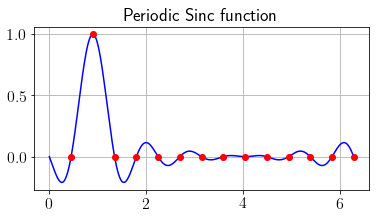

In [3]:
# Example plot of sinc(x)
plt.figure(figsize=(6,3))
plt.title("Periodic Sinc function")
y_test = np.zeros_like(S)
#y_test[1]=1
y_test[1]=1
plt.plot(ss, Sinc_interpolator(y_test, ss), "b-")
plt.plot(S, Sinc_interpolator(y_test, S), "ro")
plt.grid()
plt.show()

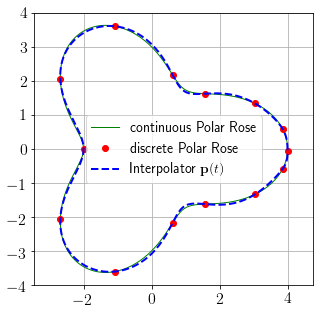

In [4]:
# Parameter for rose
n = 3

# Generate data using a polar curve
def polar_rose(s, n):
    return np.cos(n*s)+n

# Ellipse parameters
a = 2
b = 2

def ellipse(s, a, b):
    return a*b / (np.sqrt((a*np.cos(s))**2 + (b*np.sin(s))**2))

def circle(s, a):
    return ellipse(s,a,a)


rr = polar_rose(z(ss),n)
r = polar_rose(z(S),n)

#rr = circle(z(ss), a)
#r = circle(z(S), a)

# Circle R(t)
def R(t):
    return np.sqrt(a**2 - 2*t)
#rr = ellipse(ss,a,b)
#r = ellipse(S,a,b)

# Get cartesian coordinates
xx = rr*np.cos(z(ss))
yy = rr*np.sin(z(ss))

data_x = r*np.cos(z(S))
data_y = r*np.sin(z(S))
# Plot the original curve where the data (red dots) come from
# and also plot the interpolated data.
plt.figure(figsize=(5,5))
#ax1.set_title("Polar rose", fontsize=16)
plt.plot(xx , yy, "g-",lw=1.0, label=r"continuous Polar Rose")
plt.plot(data_x, data_y, "ro", label=r"discrete Polar Rose")
plt.axis("equal")
plt.grid()
plt.legend(loc="best")

res_x = Sinc_interpolator(data_x, z(ss))
res_y = Sinc_interpolator(data_y, z(ss))

plt.plot(res_x, res_y, "b--", lw=2.0, label=r"Interpolator $\mathbf{p}(t)$")
plt.axis("equal")
plt.legend(loc="best")
plt.grid(True)
plt.show()

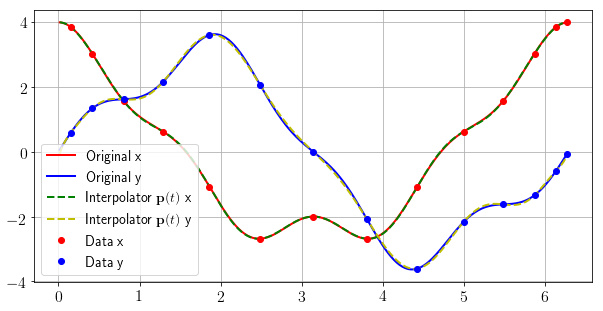

In [5]:
plt.figure(figsize=(10,5))
#ax1.set_title("Polar rose", fontsize=16)
plt.plot(z(ss), xx,"r-",lw=2.0, label=r"Original x")
plt.plot(z(ss), yy,"b-",lw=2.0, label=r"Original y")
res_x = Sinc_interpolator(data_x, ss)
res_y = Sinc_interpolator(data_y, ss)

plt.plot(z(ss), res_x, "g--", lw=2.0, label=r"Interpolator $\mathbf{p}(t)$ x")
plt.plot(z(ss), res_y, "y--", lw=2.0, label=r"Interpolator $\mathbf{p}(t)$ y")
plt.plot(z(S), data_x,"ro", label=r"Data x")
plt.plot(z(S), data_y,"bo", label=r"Data y")

plt.legend(loc='best')
plt.grid(True)
plt.show()

## Numerical simulation of periodic boundary minimizing energy

In [6]:
# Define the differentiation matrix
col = np.zeros(N)
col[1:] = 0.5*(-1.0)**np.arange(1,N)/np.tan(np.arange(1,N)*h/2.0)
row = np.zeros(N)
row[0] = col[0]
row[1:] = col[N-1:0:-1]
D = toeplitz(col,row)

# https://github.com/mikaem/spmpython/blob/master/program4.py
#h = 2.0*np.pi/N
#x = np.linspace(0, 2*np.pi, N+1)[:-1]
#col = np.hstack((0, 0.5*(-1.)**(np.arange(1, N))/np.tan(np.arange(1, N)*h/2.)))
#D = toeplitz(col, -col)

# Useful for compute D^{(2)}_N
K = np.fft.fftfreq(N) * N

# Generate alternative basis phi_j(s) as a combination
# of the differentiation matrix rows with Sinc_i(s)
def Phi_j(s, j):
    comp = D[:,j]
    return Sinc_interpolator(comp, s)

In [7]:
# Quadrature order and sampling
#M = 4*N
M = 4*N
s_int = np.linspace(0.0, 2.0*np.pi, M)

# Phi_j(s) function evaluated at integration grid for each j
Phi_j_int = np.zeros((N,M))
for j in range(N):
    Phi_j_int[j] = Phi_j(s_int, j)
    
# Sinc_i(s) function evaluated at integration grid for each i
Sinc_i_int = np.zeros((N,M))
for i in range(N):
    Sinc_i_int[i] = Sinc(s_int - S[i])

# Alias for x(s) and y(s)
def xi(comp, s):
    return Sinc_interpolator(comp, s)

# Partial derivatives of xi with respect to s by component
def l(comp, s):
    dcomp = D.dot(comp)
    return Sinc_interpolator(dcomp, s)

# Partial derivatives of l with respect to s by component
def dl(comp, s):
    comphat=np.fft.fft(comp)
    W=(-K**2)*comphat
    dcomp=np.real(np.fft.ifft(W))
    return Sinc_interpolator(dcomp, s)

# Partial derivative of lx/||l|| with respect to s
def derivative_unit_lx(lx, ly, dlxds, dlyds):
    num = ly * (ly * dlxds - lx * dlyds)
    denom = (lx**2.0+ly**2.0)**1.5
    return num / denom

# Partial derivative of ly/||l|| with respect to s
def derivative_unit_ly(lx, ly, dlxds, dlyds):
    num = -lx * (ly * dlxds - lx * dlyds)
    denom = (lx**2.0+ly**2.0)**1.5
    return num / denom

# Integral dyds(s)*Sinc_i(s) from 0 to 2pi
def int_dyds_times_sinc_i(ly_int, i):
    return np.trapz(ly_int * Sinc_i_int[i], s_int)

# Integral x(s)*Phi_j(s) from 0 to 2pi
def int_x_times_Phi_j(x_int, j):
    return np.trapz(x_int, Phi_j_int[j])

# Integral d(l/||l||)ds*Sinc_i(s) from 0 to 2pi
def int_derivative_unit_lx_times_sinc_i(lx_int, ly_int, dlxds_int, dlyds_int, i):
    f = ly_int*(ly_int * dlxds_int - lx_int * dlyds_int) / (lx_int**2 + ly_int**2)**1.5
    f = f * Sinc_i_int[i]
    #f = f / np.sqrt(ly_int**2 + lx_int**2)
    return np.trapz(f, s_int)
 
def int_derivative_unit_ly_times_sinc_i(lx_int, ly_int, dlxds_int, dlyds_int, i):
    f = -lx_int*(ly_int * dlxds_int - lx_int * dlyds_int) / (lx_int**2 + ly_int**2)**1.5
    f = f * Sinc_i_int[i]
    #f = f / np.sqrt(ly_int**2 + lx_int**2)
    return np.trapz(f, s_int)

def int_derivative_unit_lx_times_sinc_i_with_term(lx_int, ly_int, dlxds_int, dlyds_int, i):
    f = ly_int*(ly_int * dlxds_int - lx_int * dlyds_int) / (lx_int**2 + ly_int**2)**1.5
    f = f * Sinc_i_int[i]
    f = f / np.sqrt(ly_int**2 + lx_int**2)
    return np.trapz(f, s_int)

def int_derivative_unit_ly_times_sinc_i_with_term(lx_int, ly_int, dlxds_int, dlyds_int, i):
    f = -lx_int*(ly_int * dlxds_int - lx_int * dlyds_int) / (lx_int**2 + ly_int**2)**1.5
    f = f * Sinc_i_int[i]
    f = f / np.sqrt(ly_int**2 + lx_int**2)
    return np.trapz(f, s_int)

# Integral of x(s)*dyds(s) from 0 to 2pi
def int_x_times_dyds(x_int, ly_int):
    return np.trapz(x_int * ly_int, s_int)

# Integral of -y(s)*dyds(s) from 0 to 2pi
def int_minus_y_times_dxds(y_int, lx_int):
    return np.trapz(-y_int * lx_int, s_int)

# Area of boundary in polar coordinates
# Integral of 1/2 * R^2(s) from 0 to 2pi where R^2(s) = x^2(s) + y^2(s)
def Area(x_int, y_int):
    f = 0.5*(x_int**2 + y_int**2)
    return np.trapz(f, s_int)

# Derivative of Area with respect to time
# Integral of R(s) * dR(s)/dt from 0 to 2pi
def AreaPrime(x_int_0, y_int_0, x_int_1, y_int_1, dt):
    norm_xi_0 = np.sqrt(x_int_0**2 + y_int_0**2)
    norm_xi_1 = np.sqrt(x_int_1**2 + y_int_1**2)
    dnormxi_dt = (norm_xi_1 - norm_xi_0) / dt
    f = norm_xi_0 * dnormxi_dt
    return np.trapz(f, s_int)

# Arclength of boundary
def arclength(lx_int, ly_int):
    return np.trapz(np.sqrt(lx_int**2 + ly_int**2), s_int)

## Stability Analysis functions and definition of $\dot{\mathbf{x}} = F(\mathbf{x},t)$

In [8]:
def F(X, t, EQ, beta, A0):
    """
        Get RHS of dynamic system.
        Args:
            X: stacked vector of data in the form [x1,x2,...xn,y1,y2,...,yn]
    """
    data_x = X[:N]
    data_y = X[N:]
    lx = D.dot(data_x)
    ly = D.dot(data_y)
    comphat=np.fft.fft(data_x)
    W=(-K**2)*comphat
    dlxds = np.real(np.fft.ifft(W))
    comphat=np.fft.fft(data_y)
    W=(-K**2)*comphat
    dlyds = np.real(np.fft.ifft(W))
    if EQ == 0:
        norm_li = lambda i: np.sqrt(lx[i]**2 + ly[i]**2)
        x_int = Sinc_interpolator(data_x, s_int)
        y_int = Sinc_interpolator(data_y, s_int)
        lx_int = Sinc_interpolator(lx, s_int)
        ly_int = Sinc_interpolator(ly, s_int)
        dlxds_int = Sinc_interpolator(dlxds, s_int)
        dlyds_int = Sinc_interpolator(dlyds, s_int)
        # Area of the figure using Green
        A = int_x_times_dyds(x_int, ly_int)
        vx = np.array([(int_derivative_unit_lx_times_sinc_i(lx_int, ly_int, dlxds_int, dlyds_int, i) * (N/(2*np.pi)) / norm_li(i) - 
                        beta*(A-A0)*int_dyds_times_sinc_i(ly_int, i)) for i in range(N)])
        vy = np.array([(int_derivative_unit_ly_times_sinc_i(lx_int, ly_int, dlxds_int, dlyds_int, j) * (N/(2*np.pi)) / norm_li(j) -
                        beta*(A-A0)*int_x_times_Phi_j(x_int,j)) for j in range(N)])
    elif EQ == 1:
        vx = derivative_unit_lx(lx, ly, dlxds, dlyds) / np.sqrt(lx**2 + ly**2)
        vy = derivative_unit_ly(lx, ly, dlxds, dlyds) / np.sqrt(lx**2 + ly**2)
    Xdot = np.zeros_like(X)
    Xdot[:N] = vx
    Xdot[N:] = vy
    return Xdot

def eig(F, EQ, beta, A0, data_x, data_y, eps=1e-7):
    X = np.zeros(2*N)
    X[:N] = data_x
    X[N:] = data_y
    Jtemp = np.eye(2*N)
    #print(Jtemp)
    for i in range(2*N):
        Jtemp[i] = (F(X + eps*Jtemp[:,i], t=0, EQ=EQ, beta=beta, A0=A0) - F(X - eps*Jtemp[:,i], t=0, EQ=EQ, beta=beta, A0=A0))/(2.0*eps)
    return np.linalg.eig(Jtemp)

## Numerical Simulation

In [9]:
use_circle = False

if use_circle:
    tmax = (0.5*a**2)*0.995
    tarray = np.linspace(0, 2, 1001)
    dt = tarray[1] - tarray[0]
else:
    tmax = 4.5
    dt = 1e-2
    tarray = np.arange(0, tmax, dt)
    tarray = tarray[:-1]

print("Using dt = %f" % dt)

# Solve the position of each circle by the equation Rdot = 1/R, R0 = a
# This yields that R(t) = sqrt(a**2 - 2t)
all_radius = np.sqrt(a**2 - 2*tarray)
all_xcircle = np.outer(all_radius, np.cos(z(S)))
all_ycircle = np.outer(all_radius, np.sin(z(S)))

# Original data at interpolation points
data_x = r*np.cos(z(S))
data_y = r*np.sin(z(S))

# Initial condition
X0 = np.zeros(2*N)
X0[:N] = data_x
X0[N:] = data_y

# Solve the numerical simulation
beta = 0.0
#A0 = np.pi*a*b
x_int = Sinc_interpolator(data_x, s_int)
y_int = Sinc_interpolator(data_y, s_int)
A0 = Area(x_int, y_int)
EQ = 0
out = odeint(F, X0, tarray, args=(EQ, beta, A0))

# Recover all data and compute quantities
all_data_x = out[:,:N]
all_data_y = out[:,N:]

sim_radius = np.mean(np.sqrt(all_data_x**2 + all_data_y**2), axis=1)

all_lx = D.dot(all_data_x.T).T
all_ly = D.dot(all_data_y.T).T

comphat=np.fft.fft(all_data_x, axis=1)
W=(-K**2)*comphat
all_dlxds = np.real(np.fft.ifft(W, axis=1))

comphat=np.fft.fft(all_data_y, axis=1)
W=(-K**2)*comphat
all_dlyds = np.real(np.fft.ifft(W, axis=1))

areas = np.zeros_like(tarray)
areas_2 = np.pi*sim_radius**2
real_areas = np.pi*all_radius**2

energies = np.zeros_like(tarray)

all_dunit_lx = np.zeros((len(tarray),N))
all_dunit_ly = np.zeros((len(tarray),N))


for k, t in enumerate(tarray):
    x_int = Sinc_interpolator(all_data_x[k], s_int)
    y_int = Sinc_interpolator(all_data_y[k], s_int)
    lx_int = Sinc_interpolator(all_lx[k], s_int)
    ly_int = Sinc_interpolator(all_ly[k], s_int)
    dlxds_int = Sinc_interpolator(all_dlxds[k], s_int)
    dlyds_int = Sinc_interpolator(all_dlyds[k], s_int)
    
    # Compute for each time derivative of unit vector
    all_dunit_lx[k] = derivative_unit_lx(all_lx[k], all_ly[k], all_dlxds[k], all_dlyds[k])
    all_dunit_ly[k] = derivative_unit_ly(all_lx[k], all_ly[k], all_dlxds[k], all_dlyds[k])
    # Compute areas from data obtained from simulation using Green's function
    areas[k] = int_x_times_dyds(x_int, ly_int)
    # Compute energy for each time
    energies[k] = arclength(lx_int, ly_int)
print("Done")

Using dt = 0.010000


/home/asazo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


Done


In [10]:
def plot(fig, ax1, ax2, ax3, ax4, ax5, ax6, k=0, use_circle=True, save=False):
    data_x = all_data_x[k]
    data_y = all_data_y[k]
    X = np.concatenate([data_x, data_y])

    xinterp = Sinc_interpolator(data_x, ss)
    yinterp = Sinc_interpolator(data_y, ss)
    
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()
    
    ax1.set_title("Boundary at time %f (iter #%d)" % (k*dt, k))
    ax1.plot(xinterp, yinterp, "r-")
    ax1.plot(data_x, data_y, "ro", ms=6, label="simulated")
    if use_circle:
        #ax1.plot(all_xcircle[k], all_ycircle[k], "kd", ms=5, label="real")
        ax1.plot(R(tarray[k])*np.cos(ss), R(tarray[k])*np.sin(ss), "k--", lw=1.0, label="real")
    Xdot = F(X, 0, EQ, beta, A0)
    vx = Xdot[:N]
    vy = Xdot[N:]
    ax1.quiver(data_x, data_y, vx, vy, color="b", headwidth=5, label=r"Velocity")
    ax1.grid()
    if use_circle:
        ax1.set_xlim(-a,a)
        ax1.set_ylim(-a,a)
    else:
        ax1.set_xlim(np.min(all_data_x), np.max(all_data_x))
        ax1.set_ylim(np.min(all_data_y), np.max(all_data_y))
    ax1.set_xlabel(r"$x$")
    ax1.set_ylabel(r"$y$")
    ax1.legend(loc='upper right')
        
    ax2.set_title("Boundary (zoom)")
    if use_circle:
        ax2.plot(R(tarray[k])*np.cos(ss), R(tarray[k])*np.sin(ss), "k--", lw=1.5, label="real")
    ax2.plot(xinterp, yinterp, "r-")
    ax2.plot(data_x, data_y, "ro", ms=6)
    Xdot = F(X, 0, EQ, beta, A0)
    vx = Xdot[:N]
    vy = Xdot[N:]
    ax2.quiver(data_x, data_y, vx, vy, color="b", headwidth=5)
    ax2.grid()
    ax2.set_xlabel(r"$x$")
    ax2.set_ylabel(r"$y$")
    
    #Lam, V = eig(F, EQ, beta, A0, data_x, data_y, eps=1e-7)
    #print("Eigenvalues:", np.sort(Lam))
    
    ax3.set_title("Boundary Area")
    if use_circle:
        ax3.plot(tarray, areas, 'rd', label="Simulated", ms=2.0)
        ax3.plot(tarray, real_areas, 'k-', label=r"$\pi R^2(t)$")
    else:
        ax3.plot(tarray, areas, 'r-', label="Simulated")
    ax3.set_xlabel(r"$t$")
    ax3.plot(tarray[k], areas[k], marker="o", markersize=6, markeredgecolor='k', label="Current value", color="gold")
    ax3.legend(loc='best')
    ax3.grid()
    
    ax4.set_title(r"$dA/dt$")
    dAdt = np.diff(areas) / dt
    #dAdt_2 = np.diff(areas_2) / dt
    if use_circle:
        ax4.plot(tarray, -np.pi*2*np.ones_like(tarray), "k-", label="theoretical")
    ax4.plot(tarray[:-1], dAdt, 'r-', label="Simulated")
    ax4.plot(tarray[k], dAdt[k], marker="o", markersize=6, markeredgecolor='k', label="Current value", color="gold")
    #ax3.plot(tarray[:-1], dAdt_2, 'b.--', label="Simulated using radii")
    ax4.legend(loc='best')
    ax4.grid()
    ax4.set_xlabel(r"$t$")
    
    ax5.set_title(r"Energy (as arclength)")
    ax5.plot(tarray, energies, color="seagreen", lw=2.0)
    ax5.plot(tarray[k], energies[k], color="gold", markersize=6, marker="o", markeredgecolor='k', label="Current value")
    ax5.set_xlabel(r"t")
    ax5.legend(loc='best')
    ax5.grid()
    
    ax6.set_title(r"dE/dt")
    dEdt = np.diff(energies) / dt
    ax6.plot(tarray[:-1], dEdt, color="seagreen", lw=2.0)
    ax6.plot(tarray[k], dEdt[k], color="gold", markersize=6, marker="o", markeredgecolor='k', label="Current value")
    ax6.set_xlabel(r"t")
    ax6.legend(loc='best')
    ax6.grid()
    
    
    #ax4.set_title(r"Comparative of $\frac{\partial}{\partial s} \left( \mathbf{l}(s,t) / ||\mathbf{l}(s,t)||_2 \right)$")
    #ax4.plot(S, all_dunit_lx[k], 'bd', label=r"Sim. x-comp")
    #ax4.plot(S, all_dunit_ly[k], 'rd', label=r"Sim. y-comp")
    #ax4.plot(ss, -np.cos(ss),"b-", label=r"$-\cos (s)$")
    #ax4.plot(ss, -np.sin(ss),"r-", label="$-\sin (s)$")
    #ax4.legend(loc='best')
    #ax4.grid()
    
    #ax5.set_title("Radius")
    #ax5.plot(all_radius, 'k-',label=r"$R(t) = \sqrt{a^2 - 2t}$")
    #ax5.plot(sim_radius, 'r.', label=r"Simulated")
    #ax5.legend(loc='best')
    #ax5.grid()
    if save:
        plt.savefig("plots/"+str(k)+".png")
    else:
        plt.show()

make_video = False

if make_video:
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(15,10))
    for k, t in enumerate(tarray[:-1]):
        plot(fig, ax1, ax2, ax3, ax4, ax5, ax6, k, use_circle=use_circle, save=True)
    plt.close(fig)
else:
    def plot_interact(k=0):
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(15,10))
        plot(fig, ax1, ax2, ax3, ax4, ax5, ax6, k, use_circle=use_circle, save=False)
    interact(plot_interact, k=(0,len(tarray)-2,1))

A Jupyter Widget

In [84]:
################## THIS PLOT CELL IS FOR THESIS #############################
def plot_area_thesis(size=(12,3.6), use_circle=True, sim_color='r', teo_color='b',
                    precision=2):
    fig, ((ax1, ax2))= plt.subplots(1,2, figsize=size, sharey=False, sharex=False)
    if use_circle:
        fig.suptitle("Circular boundary area and rate of change", y=1.1)
    else:
        fig.suptitle("Non-regular boundary area and rate of change", y=1.1)
    data_x = all_data_x[k]
    data_y = all_data_y[k]
    X = np.concatenate([data_x, data_y])

    xinterp = Sinc_interpolator(data_x, ss)
    yinterp = Sinc_interpolator(data_y, ss)
    
    ax1.clear()
    ax2.clear()

    prep = np.arange(0, len(tarray), precision)
    tmp_tarray = tarray[prep]
    tmp_real_areas = real_areas[prep]
    tmp_areas = real_areas[prep]
    
    if use_circle:
        if precision == 1:
            ax1.plot(tarray, real_areas, '-', label="Theoretical", lw=2.0, color=teo_color)
            ax1.plot(tarray, areas, '-', label="Simulated", color=sim_color)
        else:
            ax1.plot(tmp_tarray, tmp_real_areas, 'x', label="Theoretical", color=teo_color)
            ax1.plot(tmp_tarray, tmp_areas, '.', label="Simulated", color=sim_color)
        #ax1.plot(areas - real_areas)
        ax1.legend(loc='best')
    else:
        ax1.plot(tarray, areas, '-', color=sim_color)
    ax1.set_xlabel(r"$t$")
    ax1.set_ylabel(r"$A(t)$")
    ax1.grid(zorder='-1', alpha=0.5)
    
    ax2.set_ylabel(r"$\dfrac{dA}{dt}(t)$")
    dAdt = np.diff(areas) / dt
    #dAdt = np.gradient(areas, dt)
    #dAdt_2 = np.diff(areas_2) / dt
    if use_circle:
        ax2.plot(tarray, -np.pi*2*np.ones_like(tarray), "-", label="Theoretical", color=teo_color)
        ax2.plot(tarray[:-2], dAdt[:-1], '-', label="Simulated", color=sim_color)
        ax2.legend(loc='best')
    else:
        ax2.plot(tarray[:-2], dAdt[:-1], '-', color=sim_color)
    ax2.grid(zorder='-1', alpha=0.5)
    ax2.set_xlabel(r"$t$")
    
    plt.tight_layout(w_pad=3)
    if use_circle:
        plt.savefig("thesis_plots/circularboundary_area.pdf", bbox_inches='tight')
    else:
        plt.savefig("thesis_plots/nonregularboundary_area.pdf", bbox_inches='tight')
    plt.show()

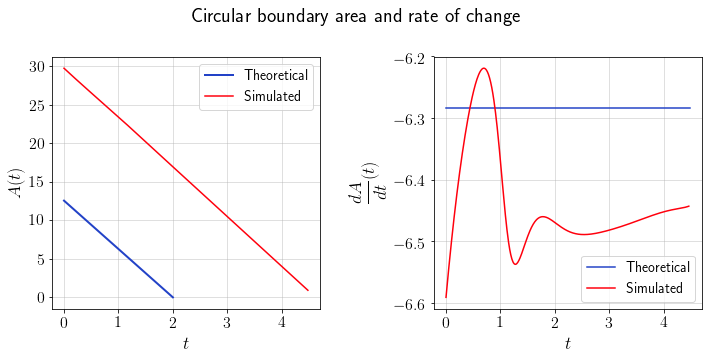

In [24]:
plot_area_thesis(size=(10,4.5), sim_color='xkcd:bright red', teo_color='xkcd:blue blue',
                precision=1, use_circle=True)

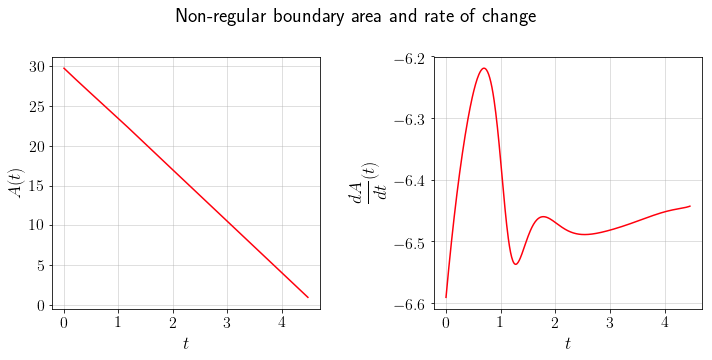

In [85]:
plot_area_thesis(size=(10,4.5), sim_color='xkcd:bright red', teo_color='xkcd:blue blue',
                precision=1, use_circle=False)

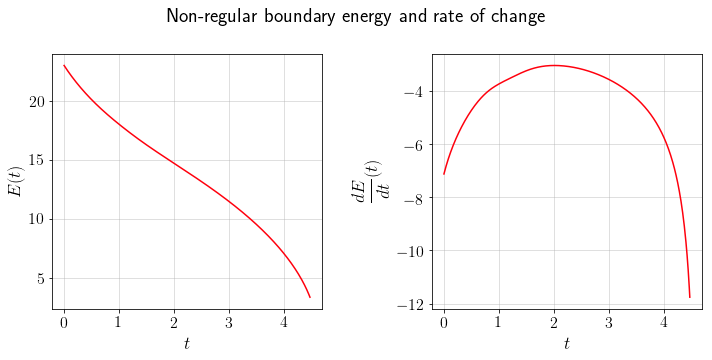

In [34]:
################## THIS PLOT CELL IS FOR THESIS #############################
def plot_energy_thesis(size=(12,3.6), use_circle=True, sim_color='r', teo_color='b',
                    precision=2):
    fig, ((ax1, ax2))= plt.subplots(1,2, figsize=size, sharey=False, sharex=False)
    if use_circle:
        fig.suptitle("Circular boundary energy and rate of change", y=1.1)
    else:
        fig.suptitle("Non-regular boundary energy and rate of change", y=1.1)
    data_x = all_data_x[k]
    data_y = all_data_y[k]
    X = np.concatenate([data_x, data_y])

    xinterp = Sinc_interpolator(data_x, ss)
    yinterp = Sinc_interpolator(data_y, ss)
    
    ax1.clear()
    ax2.clear()

    prep = np.arange(0, len(tarray), precision)
    tmp_tarray = tarray[prep]
    tmp_energies = energies[prep]
    
    if use_circle:
        if precision == 1:
            ax1.plot(tarray, 2*np.pi*all_radius, color=teo_color, label="Theoretical")
            ax1.plot(tarray, energies, '-', color=sim_color, label="Simulated")
        else:
            ax1.plot(tmp_tarray, tmp_energies, 'x', color=sim_color)
        ax1.legend(loc='best')
    else:
        ax1.plot(tarray, energies, '-', color=sim_color)
    ax1.set_xlabel(r"$t$")
    ax1.set_ylabel(r"$E(t)$")
    ax1.grid(zorder='-1', alpha=0.5)
    
    ax2.set_ylabel(r"$\dfrac{dE}{dt}(t)$")
    dEdt = np.diff(energies) / dt
    dRdt = np.diff(all_radius) / dt
    dEdt_theo = 2*np.pi*dRdt
    
    if use_circle:
        #ax2.plot(tarray, -np.pi*2*np.ones_like(tarray), "-", label="Theoretical", color=teo_color)
        ax2.plot(tarray[:-1], dEdt_theo, '-', color=teo_color, label="Theoretical")
        ax2.plot(tarray[:-1], dEdt, '-', color=sim_color, label="Simulated")
        ax2.legend(loc='best')
    else:
        ax2.plot(tarray[:-1], dEdt, '-', color=sim_color)
 
    ax2.grid(zorder='-1', alpha=0.5)
    ax2.set_xlabel(r"$t$")
    
    plt.tight_layout(w_pad=3)
    if use_circle:
        plt.savefig("thesis_plots/circularboundary_energy.pdf", bbox_inches='tight')
    else:
        plt.savefig("thesis_plots/nonregularboundary_energy.pdf", bbox_inches='tight')
    plt.show()

plot_energy_thesis(size=(10,4.5), sim_color='xkcd:bright red', teo_color='xkcd:blue blue',
                precision=1, use_circle=False)

In [35]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

IndexError: index 600 is out of bounds for axis 0 with size 449

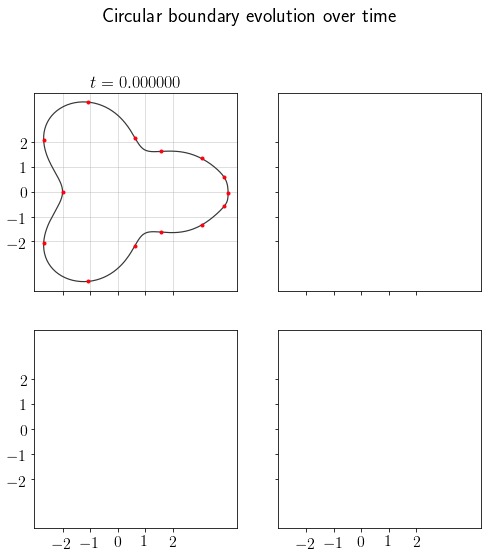

In [36]:
# Plot three stages of boundary evolution with unique legend
def plot_circle_evolution(size=(12,3.6), k1=0, k2=100, k3=200, k4=300, boundary_lw=2.0, points_size=4,
                         curve_color='xkcd:blue blue', points_color='xkcd:bright red',
                         cmap=cm.plasma):
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=size, sharey=True, sharex=True)
    fig.suptitle(r"Circular boundary evolution over time", y=1.03)
    
    # Time 0
    data_x_1 = all_data_x[k1]
    data_y_1 = all_data_y[k1]
    X1 = np.concatenate([data_x_1, data_y_1])
    xinterp_1 = Sinc_interpolator(data_x_1, ss)
    yinterp_1 = Sinc_interpolator(data_y_1, ss)
    ax1.set_title(r"$t = %f$" % tarray[k1])
    # Interpolated curve
    l1, = ax1.plot(xinterp_1, yinterp_1, '-', color=curve_color, label=r"Interpolated Circle",
                   lw=boundary_lw)
    # Theoretical curve
    #ax1.plot(R(tarray[k1])*np.cos(ss), R(tarray[k1])*np.sin(ss), "--",
    #         color="xkcd:yellowish orange", lw=1, label="Circle")
    # Data
    l2, = ax1.plot(data_x_1, data_y_1, 'o', color=points_color, ms=points_size,
                   label=r"Discrete data $\mathbf{x}_i(t)$")
    Xdot = F(X1, 0, EQ, beta, A0)
    vx = Xdot[:N]
    vy = Xdot[N:]
    vnorms1 = np.linalg.norm(np.vstack([vx,vy]), axis=0)
    ax1.set_yticks([-2,-1,0,1,2])
    ax1.set_xticks([-2,-1,0,1,2])
    ax1.grid(zorder='-1', alpha=0.5)
    ax1.set_axisbelow(True)
    
    # Time 1
    data_x_2 = all_data_x[k2]
    data_y_2 = all_data_y[k2]
    X2 = np.concatenate([data_x_2, data_y_2])
    xinterp_2 = Sinc_interpolator(data_x_2, ss)
    yinterp_2 = Sinc_interpolator(data_y_2, ss)
    ax2.set_title(r"$t = %f$" % tarray[k2])
    ax2.plot(xinterp_2, yinterp_2, lw=boundary_lw, color=curve_color)
    ax2.plot(data_x_2, data_y_2, 'o', ms=points_size, color=points_color)
    Xdot = F(X2, 0, EQ, beta, A0)
    vx = Xdot[:N]
    vy = Xdot[N:]
    vnorms2 = np.linalg.norm(np.vstack([vx,vy]), axis=0)
    ax2.set_yticks([-2,-1,0,1,2])
    ax2.set_xticks([-2,-1,0,1,2])
    ax2.grid(zorder='-1', alpha=0.5)
    ax2.set_axisbelow(True)
    
    # Time 2
    data_x_3 = all_data_x[k3]
    data_y_3 = all_data_y[k3]
    X3 = np.concatenate([data_x_3, data_y_3])
    xinterp_3 = Sinc_interpolator(data_x_3, ss)
    yinterp_3 = Sinc_interpolator(data_y_3, ss)
    ax3.set_title(r"$t = %f$" % tarray[k3])
    ax3.plot(xinterp_3, yinterp_3, lw=boundary_lw, color=curve_color)
    ax3.plot(data_x_3, data_y_3, 'o', ms=points_size, color=points_color)
    Xdot = F(X3, 0, EQ, beta, A0)
    vx = Xdot[:N]
    vy = Xdot[N:]
    vnorms3 = np.linalg.norm(np.vstack([vx,vy]), axis=0)
    ax3.set_yticks([-2,-1,0,1,2])
    ax3.set_xticks([-2,-1,0,1,2])
    ax3.grid(zorder='-1', alpha=0.5)
    
    # Time 4
    data_x_4 = all_data_x[k4]
    data_y_4 = all_data_y[k4]
    X4 = np.concatenate([data_x_4, data_y_4])
    xinterp_4 = Sinc_interpolator(data_x_4, ss)
    yinterp_4 = Sinc_interpolator(data_y_4, ss)
    ax4.set_title(r"$t = %f$" % tarray[k4])
    ax4.plot(xinterp_4, yinterp_4, lw=boundary_lw, color=curve_color)
    ax4.plot(data_x_4, data_y_4, 'o', ms=points_size, color=points_color)
    Xdot = F(X4, 0, EQ, beta, A0)
    vx = Xdot[:N]
    vy = Xdot[N:]
    vnorms4 = np.linalg.norm(np.vstack([vx,vy]), axis=0)
    ax4.set_yticks([-2,-1,0,1,2])
    ax4.set_xticks([-2,-1,0,1,2])
    ax4.grid(zorder='-1', alpha=0.5)

    # Velocity vectors
    all_vnorms1= np.hstack([vnorms1,vnorms2,vnorms3, vnorms4])
    all_vnorms2= np.hstack([vnorms2,vnorms3,vnorms4, vnorms1])
    all_vnorms3= np.hstack([vnorms3,vnorms4,vnorms1, vnorms2])
    all_vnorms4= np.hstack([vnorms4,vnorms1,vnorms2, vnorms3])
                           
    QV1 = ax1.quiver(data_x_1, data_y_1, vx, vy, all_vnorms1, headwidth=4, 
                     label=r"Velocity direction", cmap=cmap, scale=40)
    QV2 = ax2.quiver(data_x_2, data_y_2, vx, vy, all_vnorms2, headwidth=4, 
                     cmap=cmap, scale=33)
    QV3 = ax3.quiver(data_x_3, data_y_3, vx, vy, all_vnorms3, headwidth=4,
                    cmap=cmap, scale=30)
    QV4 = ax4.quiver(data_x_4, data_y_4, vx, vy, all_vnorms4, headwidth=4,
                    cmap=cmap, scale=26)
        
    cbar_ax = fig.add_axes([0.95, 0.12, 0.03, 0.76])
    clb = fig.colorbar(QV1, cax=cbar_ax)
    cbar_ax.set_title(r"$||\mathbf{v}(t)||$")
    
    handles, labels = ax1.get_legend_handles_labels()
    # Legends
    lgd = fig.legend([handles[0], handles[1]], [labels[0], labels[1]], 
                     bbox_to_anchor=(0.71,0.4), loc='center')
    fig.text(0.5, 0.04, r'$x(s)$', ha='center', fontsize=18)
    fig.text(0.04, 0.5, r'$y(s)$', ha='center', fontsize=18, rotation='vertical')
    #plt.legend(handles, labels, handler_map={l1: HandlerLine2D(numpoints=1)})
    plt.savefig("thesis_plots/circularboundary.pdf", bbox_inches='tight')
    plt.show()


cmap_custom = truncate_colormap(cm.Blues, 0.4, 1)

plot_circle_evolution(size=(8,8), k1=0, k2=600, k3=800, k4=950, boundary_lw=1.2,points_size=3,
                     curve_color='xkcd:dark gray', points_color='xkcd:bright red',
                     cmap=cmap_custom)

1.05581899853
0.634744373796
1.05581899853 1.05581899853 1.05581899853 1.05581899853


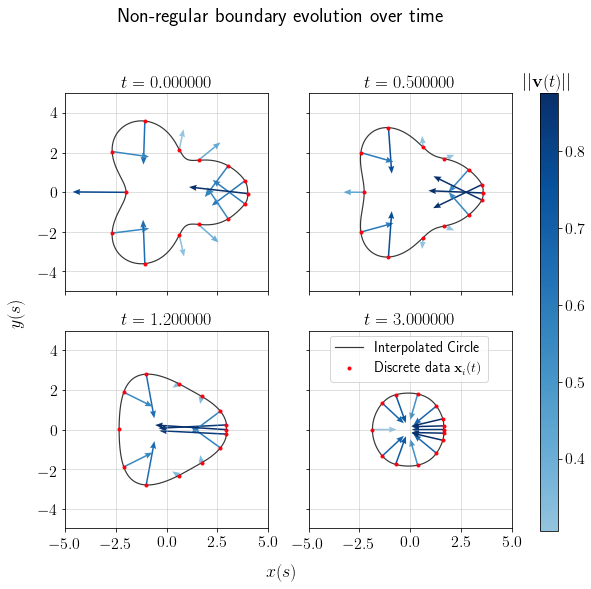

In [83]:
# Plot three stages of boundary evolution with unique legend
def plot_boundary_evolution(size=(12,3.6), k1=0, k2=100, k3=200, k4=300, boundary_lw=2.0, points_size=4,
                         curve_color='xkcd:blue blue', points_color='xkcd:bright red',
                         cmap=cm.plasma):
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=size, sharey=True, sharex=True)
    fig.suptitle(r"Non-regular boundary evolution over time", y=1.03)
    
    # Time 0
    data_x_1 = all_data_x[k1]
    data_y_1 = all_data_y[k1]
    X1 = np.concatenate([data_x_1, data_y_1])
    xinterp_1 = Sinc_interpolator(data_x_1, ss)
    yinterp_1 = Sinc_interpolator(data_y_1, ss)
    ax1.set_title(r"$t = %f$" % tarray[k1])
    # Interpolated curve
    l1, = ax1.plot(xinterp_1, yinterp_1, '-', color=curve_color, label=r"Interpolated Circle",
                   lw=boundary_lw)
    # Theoretical curve
    #ax1.plot(R(tarray[k1])*np.cos(ss), R(tarray[k1])*np.sin(ss), "--",
    #         color="xkcd:yellowish orange", lw=1, label="Circle")
    # Data
    l2, = ax1.plot(data_x_1, data_y_1, 'o', color=points_color, ms=points_size,
                   label=r"Discrete data $\mathbf{x}_i(t)$")
    Xdot = F(X1, 0, EQ, beta, A0)
    vx = Xdot[:N]
    vy = Xdot[N:]
    vnorms1 = np.linalg.norm(np.vstack([vx,vy]), axis=0)
    QV1 = ax1.quiver(data_x_1, data_y_1, vx, vy, vnorms1, headwidth=4, 
                     label=r"Velocity direction", cmap=cmap, scale=3)
    ax1.set_xlim(-5,5)
    ax1.set_ylim(-5,5)
    #ax1.set_yticks([-2,-1,0,1,2])
    #ax1.set_xticks([-3,-2,-1,0,1,2,3,4])
    ax1.grid(zorder='-1', alpha=0.5)
    ax1.set_axisbelow(True)
    
    # Time 1
    data_x_2 = all_data_x[k2]
    data_y_2 = all_data_y[k2]
    X2 = np.concatenate([data_x_2, data_y_2])
    xinterp_2 = Sinc_interpolator(data_x_2, ss)
    yinterp_2 = Sinc_interpolator(data_y_2, ss)
    ax2.set_title(r"$t = %f$" % tarray[k2])
    ax2.plot(xinterp_2, yinterp_2, lw=boundary_lw, color=curve_color)
    ax2.plot(data_x_2, data_y_2, 'o', ms=points_size, color=points_color)
    Xdot = F(X2, 0, EQ, beta, A0)
    vx = Xdot[:N]
    vy = Xdot[N:]
    vnorms2 = np.linalg.norm(np.vstack([vx,vy]), axis=0)
    QV2 = ax2.quiver(data_x_2, data_y_2, vx, vy, vnorms2, headwidth=4, cmap=cmap, scale=3)
    #ax2.set_yticks([-2,-1,0,1,2])
    #ax2.set_xticks([-2,-1,0,1,2])
    ax2.grid(zorder='-1', alpha=0.5)
    ax2.set_axisbelow(True)
    
    # Time 2
    data_x_3 = all_data_x[k3]
    data_y_3 = all_data_y[k3]
    X3 = np.concatenate([data_x_3, data_y_3])
    xinterp_3 = Sinc_interpolator(data_x_3, ss)
    yinterp_3 = Sinc_interpolator(data_y_3, ss)
    ax3.set_title(r"$t = %f$" % tarray[k3])
    ax3.plot(xinterp_3, yinterp_3, lw=boundary_lw, color=curve_color)
    ax3.plot(data_x_3, data_y_3, 'o', ms=points_size, color=points_color)
    Xdot = F(X3, 0, EQ, beta, A0)
    vx = Xdot[:N]
    vy = Xdot[N:]
    vnorms3 = np.linalg.norm(np.vstack([vx,vy]), axis=0)
    print(np.max(vnorms3))
    QV3 = ax3.quiver(data_x_3, data_y_3, vx, vy, vnorms3, headwidth=4, cmap=cmap, scale=3)
    ax3.grid(zorder='-1', alpha=0.5)
    
    # Time 4
    data_x_4 = all_data_x[k4]
    data_y_4 = all_data_y[k4]
    X4 = np.concatenate([data_x_4, data_y_4])
    xinterp_4 = Sinc_interpolator(data_x_4, ss)
    yinterp_4 = Sinc_interpolator(data_y_4, ss)
    ax4.set_title(r"$t = %f$" % tarray[k4])
    ax4.plot(xinterp_4, yinterp_4, lw=boundary_lw, color=curve_color)
    ax4.plot(data_x_4, data_y_4, 'o', ms=points_size, color=points_color)
    Xdot = F(X4, 0, EQ, beta, A0)
    vx = Xdot[:N]
    vy = Xdot[N:]
    vnorms4 = np.linalg.norm(np.vstack([vx,vy]), axis=0)
    print(np.max(vnorms4))
    QV4 = ax4.quiver(data_x_4, data_y_4, vx, vy, vnorms4, headwidth=4, cmap=cmap, scale=4)
    #ax4.set_yticks([-2,-1,0,1,2])
    #ax4.set_xticks([-2,-1,0,1,2])
    ax4.grid(zorder='-1', alpha=0.5)

    # Velocity vectors
    all_vnorms1= np.hstack([vnorms1,vnorms2,vnorms3, vnorms4])
    all_vnorms2= np.hstack([vnorms2,vnorms3,vnorms4, vnorms1])
    all_vnorms3= np.hstack([vnorms3,vnorms4,vnorms1, vnorms2])
    all_vnorms4= np.hstack([vnorms4,vnorms1,vnorms2, vnorms3])

    print(np.max(all_vnorms1), np.max(all_vnorms2), np.max(all_vnorms3), np.max(all_vnorms4))
        
    cbar_ax = fig.add_axes([0.95, 0.12, 0.03, 0.76])
    clb = fig.colorbar(QV1, cax=cbar_ax)
    cbar_ax.set_title(r"$||\mathbf{v}(t)||$")
    
    handles, labels = ax1.get_legend_handles_labels()
    # Legends
    lgd = fig.legend([handles[0], handles[1]], [labels[0], labels[1]], 
                     bbox_to_anchor=(0.71,0.4), loc='center')
    fig.text(0.5, 0.04, r'$x(s)$', ha='center', fontsize=18)
    fig.text(0.04, 0.5, r'$y(s)$', ha='center', fontsize=18, rotation='vertical')
    #plt.legend(handles, labels, handler_map={l1: HandlerLine2D(numpoints=1)})
    plt.savefig("thesis_plots/nonregularboundary.pdf", bbox_inches='tight')
    plt.show()


cmap_custom = truncate_colormap(cm.Blues, 0.4, 1)

plot_boundary_evolution(size=(8,8), k1=0, k2=50, k3=120, k4=300, boundary_lw=1.2,points_size=3,
                     curve_color='xkcd:dark gray', points_color='xkcd:bright red',
                     cmap=cmap_custom)